Source code for analysis and figure reproduction for

# Adaptive social contact rates induce complex dynamics during epidemics
by Ronan F. Arthur, James H. Jones, Matthew H. Bonds, [Yoav Ram](http://www.yoavram.com), Marcus W. Feldman

The following is a Jupyter notebook that includes Python source code to reproduce the SIS model numerical results presented in Figs. 1-4 and supplementray figures.

### License

The source code is released under a [CC-BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/).

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import root
import scipy.signal
import seaborn as sns
%load_ext watermark

from rakott.mpl import fig_xlabel, fig_ylabel # https://github.com/yoavram/rakott

from ddeint import ddeint # https://github.com/Zulko/ddeint

sns.set_context('paper', font_scale=1.3)
red, blue, green = sns.color_palette('Set1', 3)

In [2]:
%watermark --iversions 

scipy      1.5.3
json       2.0.9
matplotlib 3.3.2
numpy      1.19.2
seaborn    0.11.0



# Default model parameters
Changes use `_` after parameter name.

In [3]:
N = 10000
I0 = 1
b0 = 0.05
γ = 0.08
c_hat = 0.0015
α1 = 0.02
α2 = 0.3
Δ = 3

# Deterministic discrete-time model

$$
I_{t+1} = I_t + b_t S_t I_t - \gamma I_t \quad (2.2) \\
b_t = b_0 c^*_t \quad (2.4) \\
c^*_t = \hat{c} - \alpha \frac{I_{(t-\Delta)}}{N} \quad (2.10)
$$

$$
f(I_t) = I_{t+1} = I_t^2 \big(\frac{b_0 \alpha}{N} I_{(t-\Delta)} - b_0 \hat{c} \big) + I_t (b_0 N \hat{c} -\alpha b_0 I_{(t-\Delta)} + 1 - \gamma)
\quad (2.11)
$$

$$
\frac{df}{dI} = 
1-\gamma+b_{0}\left(\hat{c} N-2 \alpha I-2 \hat{c} I+3 \alpha \frac{I^{2}}{N}\right)
$$

$$
\hat{I}_1 = \frac{\alpha +\hat{c} + \sqrt{\alpha^2 + \hat{c}^2 - 2\alpha \hat{c} + 4\frac{\alpha}{b_0 N} \gamma}}{2\frac{\alpha}{N}}
\quad (3.3) \\
\hat{I}_2 = \frac{\alpha +\hat{c} - \sqrt{\alpha^2 + \hat{c}^2 - 2\alpha \hat{c} + 4\frac{\alpha}{b_0 N} \gamma}}{2\frac{\alpha}{N}}
\quad (3.4)
$$

/Users/yoavram/miniconda3/envs/scipy/lib/python3.6/site-packages/ddeint/ddeint.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([g(tt[0])] + results)


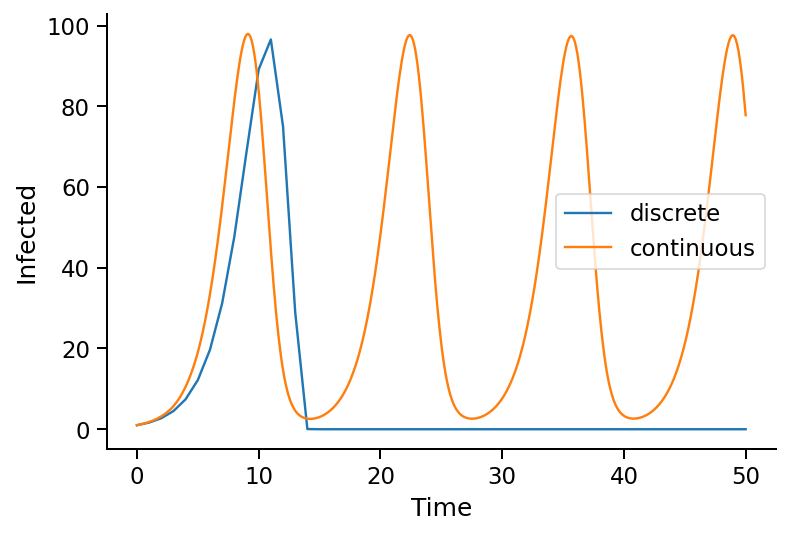

In [4]:
def f(It, IΔ, N, b0, γ, c_hat, α1, α2, min0=False, maxN=False):
    α = α2 / (2 * α1) * b0
    It1 = It * It * b0 * (α * IΔ / N - c_hat) + It * (b0 * N * c_hat - α * b0 * IΔ + 1 - γ)
    It1 = np.array(It1)
    if min0: It1[It1 < 0] = 0
    if maxN: It1[It1 > N] = N
    return It1

def dfdI(I, N, b0, γ, c_hat, α1, α2):
    α = α2 / (2 * α1) * b0
    return 1 - γ + b0 * (c_hat * N - 2 * α * I - 2 * c_hat * I + 3 * α * I * I / N)

def I2(N, b0, γ, c_hat, α1, α2):
    α = α2 / (2 * α1) * b0
    numer = α + c_hat - np.sqrt(α * α + c_hat * c_hat - 2 * α * c_hat + 4 * α * γ / (b0 * N))
    res = numer / (2 * α / N)
    if res < 0: return np.nan
    return res

def I1(N, b0, γ, c_hat, α1, α2):
    α = α2 / (2 * α1) * b0
    numer = α + c_hat + np.sqrt(α * α + c_hat * c_hat - 2 * α * c_hat + 4 * α * γ / (b0 * N))
    res = numer / (2 * α / N)
    if res < 0: return np.nan
    return res

def det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=500, min0=False, maxN=False):
    I = np.zeros(tmax+1)
    I[0] = I0
    for t in range(tmax):
        IΔ = I[t-Δ] if t >= Δ else I0
        I[t+1] = f(I[t], IΔ, N, b0, γ, c_hat, α1, α2, min0, maxN)
    return I

def dde(I, t, N, b0, γ, c_hat, α1, α2, Δ):
    return f(I(t), I(t-Δ), N, b0, γ, c_hat, α1, α2) - I(t)

def det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=500, npts=100):
    g = lambda t: I0
    t = np.linspace(0, tmax, tmax * npts)
    return t, ddeint(dde, g, t, fargs=(N, b0, γ, c_hat, α1, α2, Δ))    

I = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=50, min0=True, maxN=True)
plt.plot(I, label='discrete')
t, I = det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ, tmax=50, npts=10)
plt.plot(t, I, label='continuous')
plt.xlabel('Time')
plt.ylabel('Infected')
plt.legend()
sns.despine()

# Fig 3, $b_0$ varies

/Users/yoavram/miniconda3/envs/scipy/lib/python3.6/site-packages/ddeint/ddeint.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([g(tt[0])] + results)
/Users/yoavram/miniconda3/envs/scipy/lib/python3.6/site-packages/ddeint/ddeint.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([g(tt[0])] + results)
/Users/yoavram/miniconda3/envs/scipy/lib/python3.6/site-packages/ddeint/ddeint.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarr

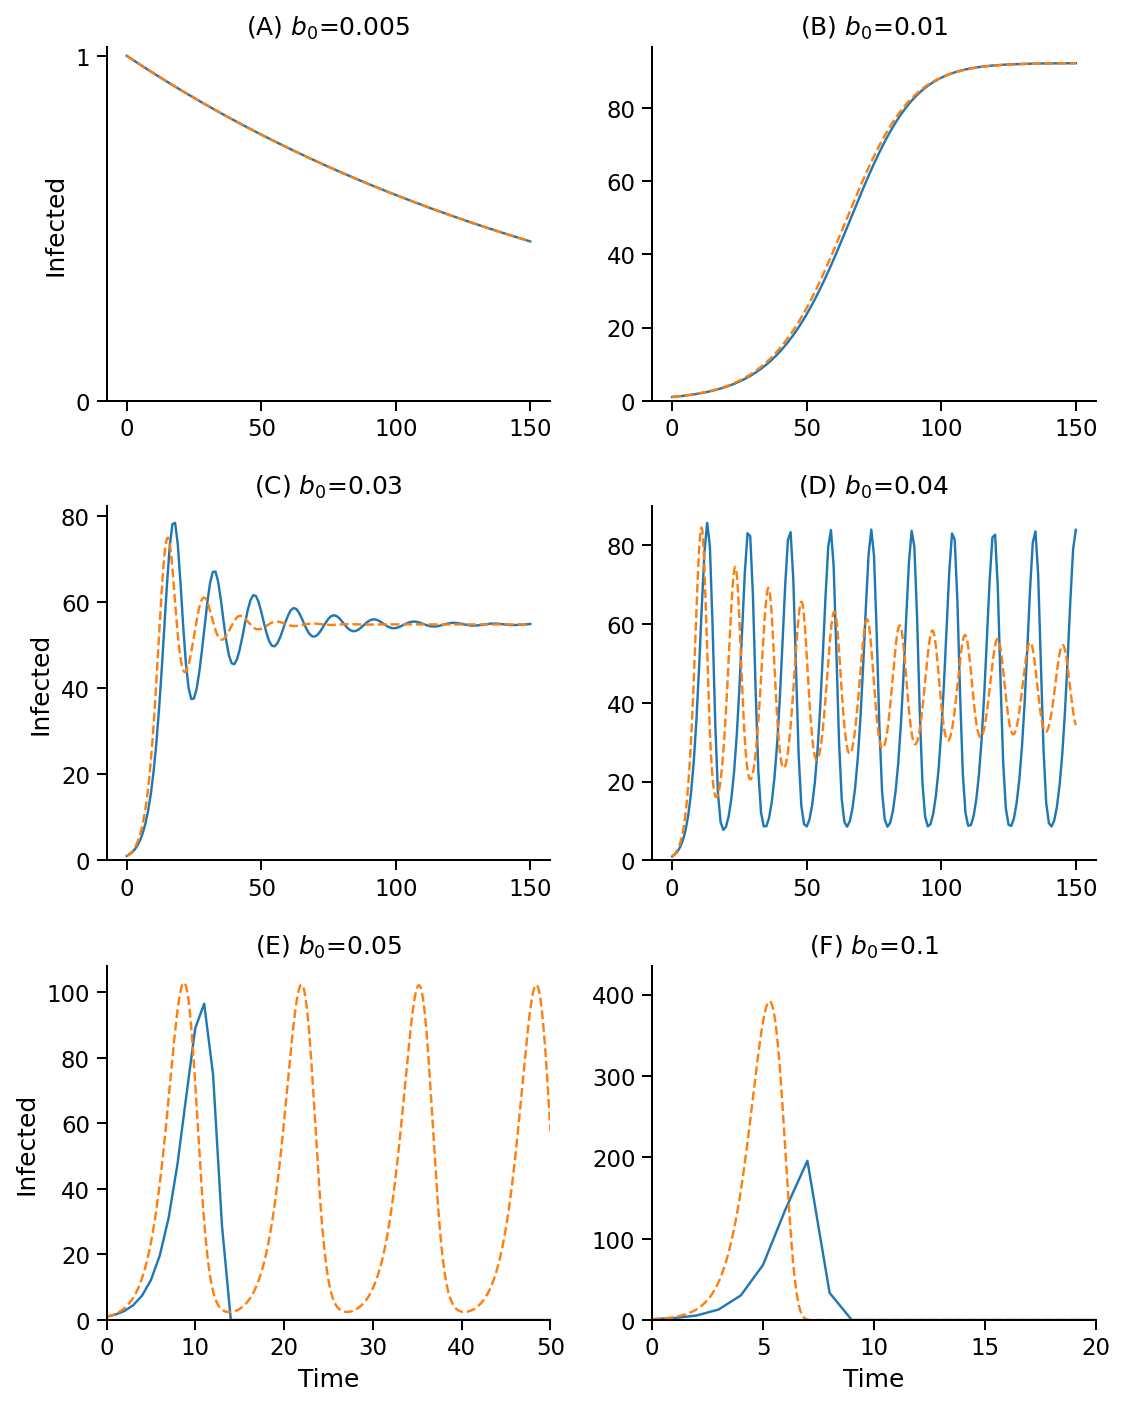

In [5]:
b0s = [0.005, 0.01, 0.03, 0.04, 0.05, 0.1]

fig, axes = plt.subplots(3, 2, figsize=(8, 10))
for b0_, ax, label in zip(b0s, axes.flat, 'ABCDEF'):
    Idis = det_dis_simulation(I0, N, b0_, γ, c_hat, α1, α2, Δ, tmax=150, min0=True, maxN=True)
    ax.plot(Idis)
    t, Icont = det_cont_simulation(I0, N, b0_, γ, c_hat, α1, α2, Δ, tmax=150)
    ax.plot(t, Icont, '--')
    ax.set_ylim(0, None)        
    ax.set_title("({}) $b_0$={}".format(label, b0_))
for ax in axes[:,0]: ax.set_ylabel('Infected')
for ax in axes[2]: ax.set_xlabel('Time')
axes[2,0].set_xlim(0, 50)
axes[2,1].set_xlim(0, 20)
axes[0,0].set_yticks([0, 1])
axes[-1,-1].set_ylim(0, max(Icont.max(), Idis.max()))

fig.tight_layout()
sns.despine()
plt.savefig('../figures/fig3.pdf', dpi=100)

# Fig 1, $\Delta$ varies

In [6]:
Δs = [0, 1, 2, 3, 4, 5]
results_Δs = []
for Δ_ in Δs:
    Idis = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=100, min0=True)
    t, Icont = det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=100)
    results_Δs.append((Idis, t, Icont))

/Users/yoavram/miniconda3/envs/scipy/lib/python3.6/site-packages/ddeint/ddeint.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([g(tt[0])] + results)


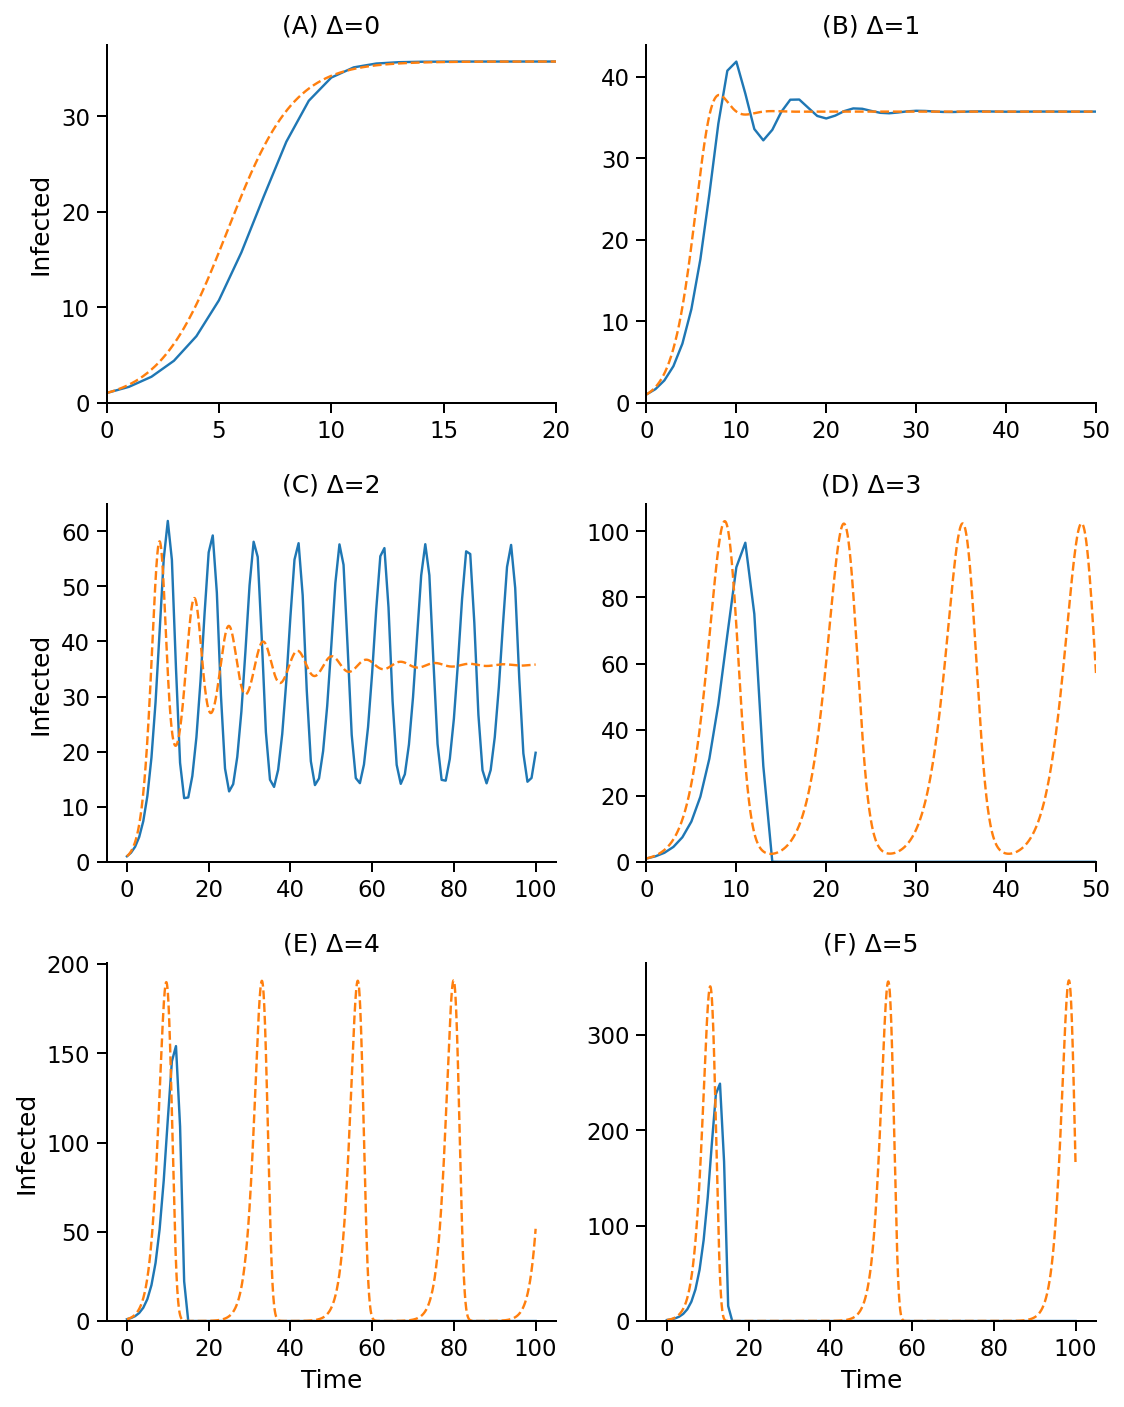

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(8, 3.33*3))
for Δ_, ax, label, (Idis, t, Icont) in zip(Δs, axes.flat, 'ABCDEF', results_Δs):
    ax.plot(Idis)
    ax.plot(t, Icont, '--')
    ax.set_ylim(0, None)
    ax.set_title("({}) Δ={}".format(label, Δ_))
axes[0,0].set_xlim(0, 20)
axes[0,1].set_xlim(0, 50)
axes[1,1].set_xlim(0, 50)
for ax in axes[:,0]: ax.set_ylabel('Infected')
for ax in axes[2]: ax.set_xlabel('Time')

fig.tight_layout()
sns.despine()
plt.savefig('../figures/fig1.pdf', dpi=100)

# Fig S5, $\Delta$=2

/Users/yoavram/miniconda3/envs/scipy/lib/python3.6/site-packages/ddeint/ddeint.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([g(tt[0])] + results)


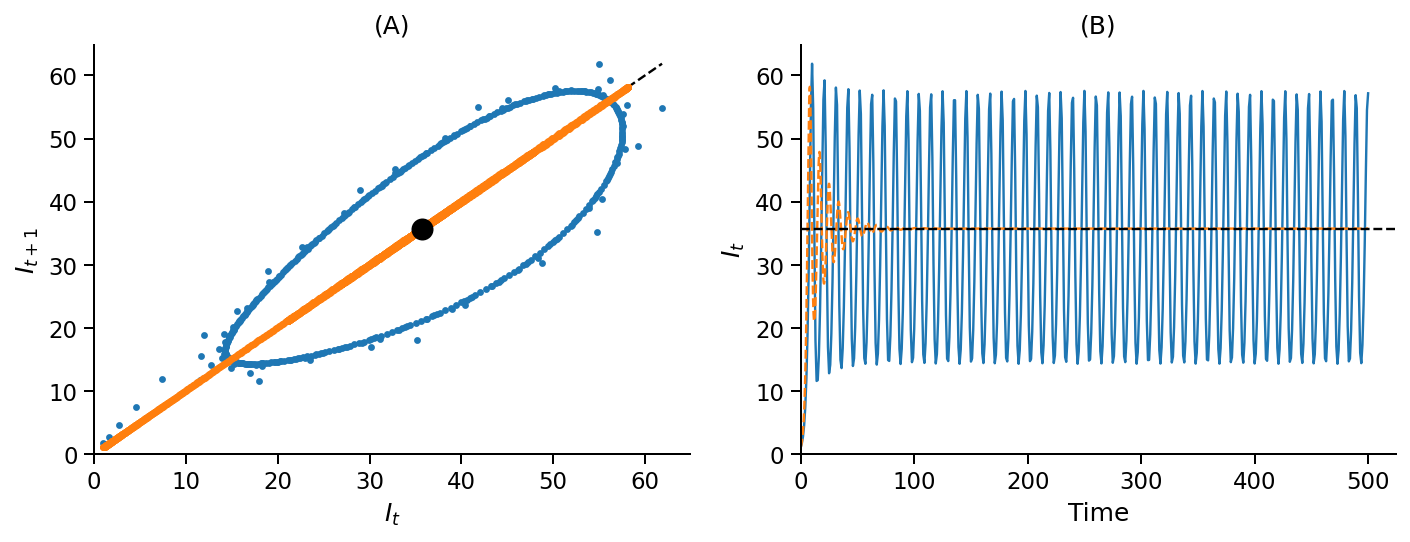

In [8]:
Δ_ = 2
tmax = 500

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
Idis = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=tmax)
ax.plot(Idis[:-1], Idis[1:], '.')
line = np.linspace(Idis.min(), Idis.max())
ax.plot(line, line, ls='--', color='k')
t, Icont = det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=tmax)
ax.plot(Icont[:-1], Icont[1:], '.')
ax.plot(I2(N, b0, γ, c_hat, α1, α2), I2(N, b0, γ, c_hat, α1, α2), 'o', color='k', markersize=10)
ax.set(xlabel='$I_t$', ylabel='$I_{t+1}$', xlim=(0, None), ylim=(0, None))

ax = axes[1]
ax.plot(Idis)
ax.plot(t, Icont, '--')
ax.axhline(I2(N, b0, γ, c_hat, α1, α2), ls='--', color='k')
ax.set(xlabel='Time', ylabel='$I_t$', xlim=(0, None), ylim=(0, None))

for ax, label in zip(axes.flat, 'ABCD'): ax.set_title("({})".format(label))

sns.despine()
fig.tight_layout()
fig.savefig('../figures/figS5.pdf')

Longer run

/Users/yoavram/miniconda3/envs/scipy/lib/python3.6/site-packages/ddeint/ddeint.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([g(tt[0])] + results)


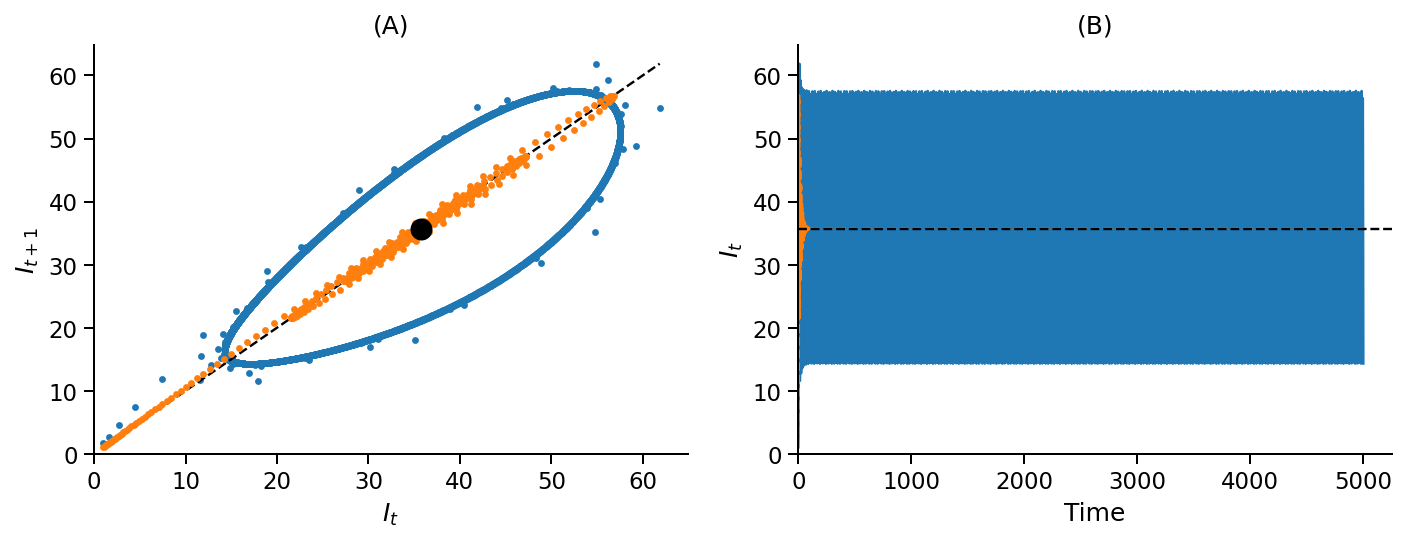

In [9]:
Δ_ = 2

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
Idis = det_dis_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=tmax*10)
ax.plot(Idis[:-1], Idis[1:], '.')
line = np.linspace(Idis.min(), Idis.max())
ax.plot(line, line, ls='--', color='k')
t, Icont = det_cont_simulation(I0, N, b0, γ, c_hat, α1, α2, Δ_, tmax=tmax*10, npts=10)
ax.plot(Icont[:-1], Icont[1:], '.')
ax.plot(I2(N, b0, γ, c_hat, α1, α2), I2(N, b0, γ, c_hat, α1, α2), 'o', color='k', markersize=10)
ax.set(xlabel='$I_t$', ylabel='$I_{t+1}$', xlim=(0, None), ylim=(0, None))

ax = axes[1]
ax.plot(Idis)
ax.plot(t, Icont, '--')
ax.axhline(I2(N, b0, γ, c_hat, α1, α2), ls='--', color='k')
ax.set(xlabel='Time', ylabel='$I_t$', xlim=(0, None), ylim=(0, None))

for ax, label in zip(axes.flat, 'ABCD'): ax.set_title("({})".format(label))

sns.despine()
fig.tight_layout()
fig.savefig('../figures/figS5-long.pdf')

Decreasing population size: this emulates SIR.

In [10]:
def det_dis_simulation_Ns(I0, Ns, b0, γ, c_hat, α1, α2, Δ, tmax=500, min0=False, maxN=False):
    I = np.zeros(tmax+1)
    I[0] = I0
    for t in range(tmax):
        IΔ = I[t-Δ] if t >= Δ else I0
        I[t+1] = f(I[t], IΔ, Ns[t], b0, γ, c_hat, α1, α2, min0, maxN)
    return I

χ = γ*b0*c_hat*50
Ns = N * np.exp(-χ * np.arange(tmax))

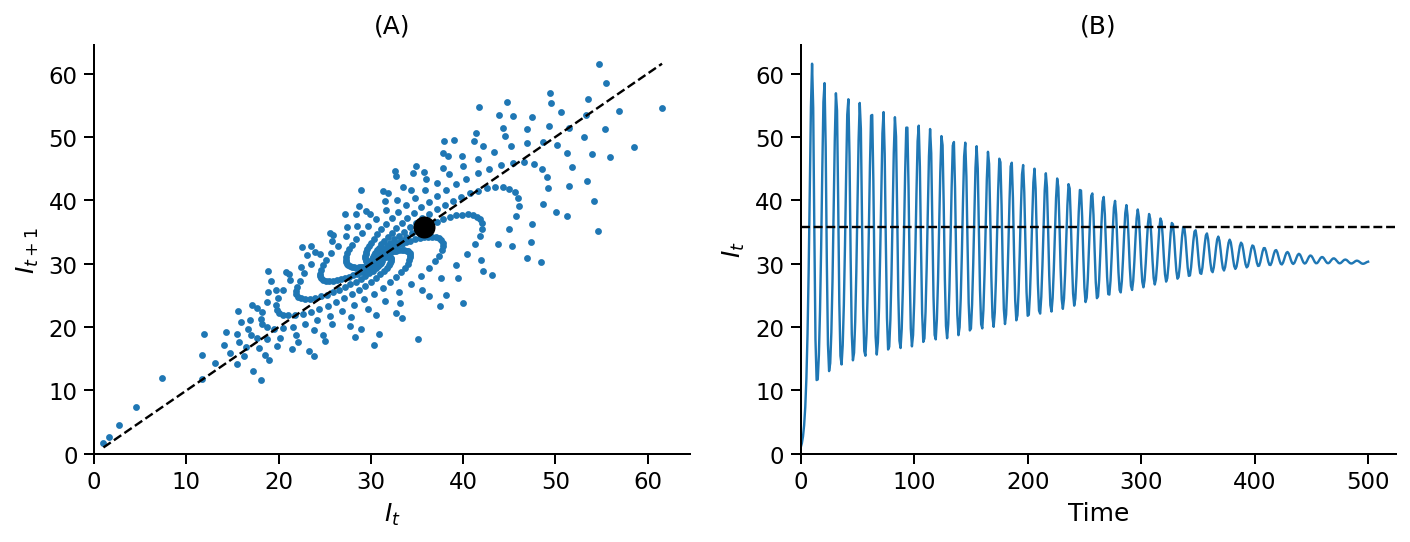

In [11]:
Δ_ = 2

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
Idis = det_dis_simulation_Ns(I0, Ns, b0, γ, c_hat, α1, α2, Δ_, tmax=tmax)
ax.plot(Idis[:-1], Idis[1:], '.')
line = np.linspace(Idis.min(), Idis.max())
ax.plot(line, line, ls='--', color='k')
# t, Icont = det_cont_simulation(I0, Ns, b0, γ, c_hat, α1, α2, Δ_, tmax=tmax)
# ax.plot(Icont[:-1], Icont[1:], '.')
ax.plot(I2(N, b0, γ, c_hat, α1, α2), I2(N, b0, γ, c_hat, α1, α2), 'o', color='k', markersize=10)
ax.set(xlabel='$I_t$', ylabel='$I_{t+1}$', xlim=(0, None), ylim=(0, None))

ax = axes[1]
ax.plot(Idis)
# ax.plot(t, Icont, '--')
ax.axhline(I2(N, b0, γ, c_hat, α1, α2), ls='--', color='k')
ax.set(xlabel='Time', ylabel='$I_t$', xlim=(0, None), ylim=(0, None))

for ax, label in zip(axes.flat, 'ABCD'): ax.set_title("({})".format(label))

sns.despine()
fig.tight_layout()
fig.savefig('../figures/figS5N.pdf')

# Fig 4, $\Delta$ = 3, $\gamma$ varies

In [12]:
N=10000
I0=1
b0=0.05
γs=[0.1,0.2,0.45,0.65,0.75]
c_hat=0.0015
α1=0.02
α2=0.3 
Δ=3

In [13]:
results_table2 = []
for γ_ in γs:
    Idis = det_dis_simulation(I0, N, b0, γ_, c_hat, α1, α2, Δ, tmax=250, min0=True, maxN=True)
    t, Icont = det_cont_simulation(I0, N, b0, γ_, c_hat, α1, α2, Δ, tmax=250)
    results_table2.append((Idis, t, Icont))

/Users/yoavram/miniconda3/envs/scipy/lib/python3.6/site-packages/ddeint/ddeint.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([g(tt[0])] + results)


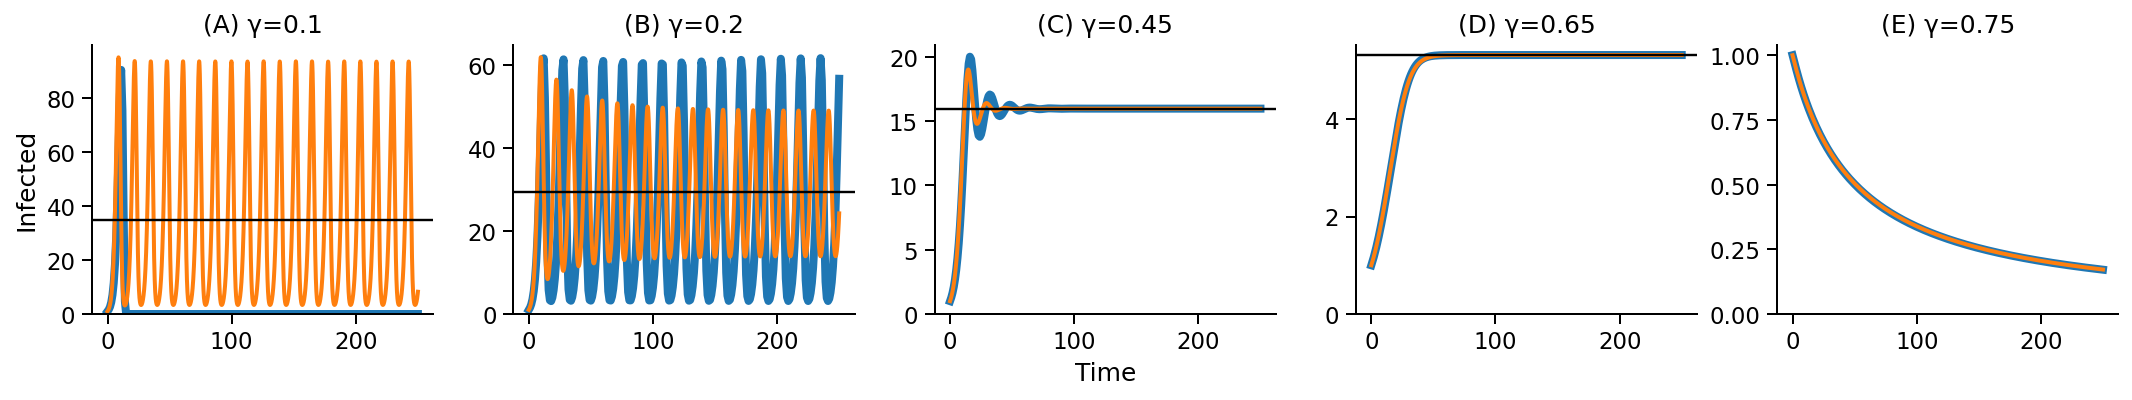

In [14]:
fig, axes = plt.subplots(1, len(γs), figsize=(15, 3), sharex=True)
for label, ax, γ_, res in zip('ABCDEF', axes.flat, γs, results_table2):
    Idis, t, Icont = res
    ax.plot(Idis, lw=4)
    ax.plot(t, Icont, '-', lw=2)
    ax.axhline(I2(N, b0, γ_, c_hat, α1, α2), color='k')
    ax.set(ylim=(0, None), title='({}) γ={}'.format(label, γ_))
axes[2].set(xlabel='Time')
axes[0].set(ylabel='Infected')
fig.tight_layout()
sns.despine()
fig.savefig('../figures/fig4.pdf', dpi=100)

# Fig 2, $I_0$ varies

In [15]:
I1_ = I1(N, b0, γ, c_hat, α1, α2)
I2_ = I2(N, b0, γ, c_hat, α1, α2)

print('I1={:.2f}\tdfdI(I1)={:.2f}'.format(I1_, dfdI(I1_, N, b0, γ, c_hat, α1, α2)))
print('I2={:.2f}\tdfdI(I2)={:.2f}'.format(I2_, dfdI(I2_, N, b0, γ, c_hat, α1, α2)))

I1=10004.28	dfdI(I1)=187.99
I2=35.72	dfdI(I2)=0.33


In [16]:
I0s = [1, 35, 50, 90]
results_I0s = []
for I0_ in I0s:
    Idis = det_dis_simulation(I0_, N, b0, γ, c_hat, α1, α2, Δ=2, tmax=250, min0=True, maxN=True)
    t, Icont = det_cont_simulation(I0_, N, b0, γ, c_hat, α1, α2, Δ=2, tmax=250)
    results_I0s.append([Idis, t, Icont])

/Users/yoavram/miniconda3/envs/scipy/lib/python3.6/site-packages/ddeint/ddeint.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([g(tt[0])] + results)


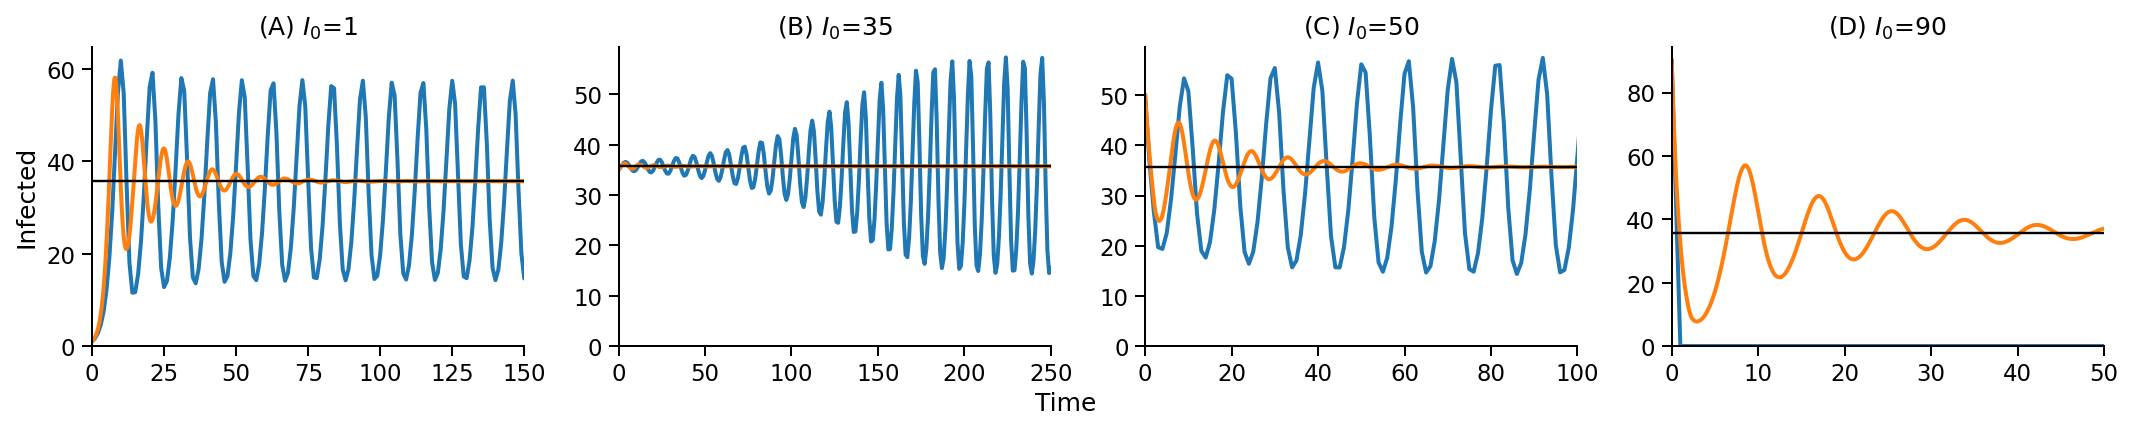

In [17]:
fig, axes = plt.subplots(1, len(I0s), figsize=(15, 3))
for label, ax, I0_, res in zip('ABCDEF', axes.flat, I0s, results_I0s):
    Idis, t, Icont = res
    ax.plot(Idis, lw=2)
    ax.plot(t, Icont, lw=2) 
    ax.axhline(I2_, color='k')
    ax.set(title='({}) $I_0$={}'.format(label, I0_), ylim=(0, None), xlim=(0, None))
axes[0].set_ylabel('Infected')
fig_xlabel(fig, 'Time')

axes[0].set_xlim(0, 150)
axes[1].set_xlim(0, 250)
axes[2].set_xlim(0, 100)
axes[3].set_xlim(0, 50)

fig.tight_layout()
sns.despine()
fig.savefig('../figures/fig2.pdf')

**End**